# Analyzing Player Retention

This project will examine the mobile puzzle game Cookie Cats. At certain points of the game, a player will occasionally encounter a gate that forces them to wait for a period of time or make an in app purchase to progress further. This is a strategy intended to enhance overall enjoyment by pacing the gameplay and giving players an enforced break from playing the game.

Where should the gate be placed? Initially, the gate was placed at level 30 but the company wanted to conduct an A/B Test where the gate was moved from level 30 to level 40 to test for player retention. When a player installed the game, they were randomly assigned to either gate 30 or gate 40. Our tests will be a bootstrap, Chi-Squared Test, and Bayesian AB Test using a significance level of 0.05 throughout.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pymc as pm

## Data Cleaning and EDA

First, we will load in the dataset and explore it to better understand what we are working with.

In [2]:
# load in the data
df = pd.read_csv("cookie_cats.csv")

# look at the first 5 rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# total number of observations
print("Total rows:", len(df))

Total rows: 90189


In [4]:
# check the data types of each variable and look for some missing values that may need to be investigated
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There doesn't look to be any missing values in any column.

We should check that each observation is a different user or if there are duplicates in the data.

In [5]:
# check the number of unique users
df["userid"].nunique()

90189

It looks like we don't have duplicate users!

Next we will check if the version groupings are similar for our A/B Test.

In [6]:
# check if groupings are rougly similar
df.groupby("version")["version"].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

Text(0, 0.5, 'Total Players')

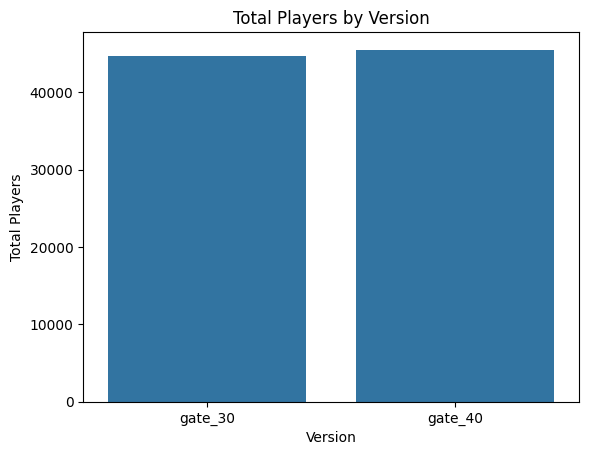

In [7]:
# create a plot to show the number of players for each version of the game
sns.countplot(data = df, x = "version")
plt.xlabel("Version")
plt.title("Total Players by Version")
plt.ylabel("Total Players")

In [8]:
# calculate the percentage of players for each version of the game
round(df["version"].value_counts(normalize = True) * 100, 2)

version
gate_40    50.44
gate_30    49.56
Name: proportion, dtype: float64

Both versions look to be similar!

The main purpose is player retention, so we can look into how many rounds users have played during the first week of the game

In [9]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


A quick look at the data, there looks to be users that didn't come back to play at either 1 or 7 days after installing, some that would be played at both, and others that are played at only one of the days. Retaining the user at 1 day and losing them at 7 would make a little sense. A player could be enjoying the game initially but lose interest after some time. We can look quickly and see what the distribution of the retention days is.

In [10]:
df.groupby(["retention_1", "retention_7"])["userid"].count().reset_index()

,retention_1,retention_7,userid
0,False,False,46437
1,False,True,3599
2,True,False,26971
3,True,True,13182


One interesting observation is that some users didn't come back to play 1 day after installing but did after 7 days. This could be be looked into further if this was done at the company and there was more data/resources available. We could check if it's definition of playing after installing. If they would have to play on day 1 or day 7 to be defined as retained, that would make sense based on what we're seeing here. But if someone were to come back to play 7 days later, they were retained after a single day even if they didn't play the game the next day after installing.

Next, we can look at the number of rounds played by users.

In [11]:
# count the number of users that cleared a certain number of rounds
roundsPlayed = df.groupby("sum_gamerounds")["userid"].count().reset_index()
roundsPlayed

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
937,2294,1
938,2438,1
939,2640,1
940,2961,1


There looks to be 3994 users during this testing period that didn't complete a single level. There is also one user who completed 49,854 levels in the testing period. This is significantly higher than any other user. We can look a little deeper at the descriptive statistics for our data.

In [12]:
# check the descriptive statistics for sum_gamerounds
df["sum_gamerounds"].describe([0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
1%           0.000000
5%           1.000000
10%          1.000000
25%          5.000000
50%         16.000000
75%         51.000000
90%        134.000000
95%        221.000000
99%        493.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

There is a significant difference in the rounds played by a user in the 99th percentile and the maximum in our dataset. We can see if a similar observation occurs when looking at number of players per rounds played.

In [13]:
# check the descriptive statistics for sum_gamerounds
roundsPlayed["sum_gamerounds"].describe([0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

count      942.000000
mean       584.921444
std       1656.069688
min          0.000000
1%           9.410000
5%          47.050000
10%         94.100000
25%        235.250000
50%        470.500000
75%        726.750000
90%       1037.900000
95%       1299.400000
99%       1970.310000
max      49854.000000
Name: sum_gamerounds, dtype: float64

With a mean higher than the median, our data is a bit right skewed. There is another big difference between the 99th percentile and maximum. We can visualize the rounds played to see if it makes sense keeping that datapoint in our analysis.

Text(0, 0.5, 'Number of Players')

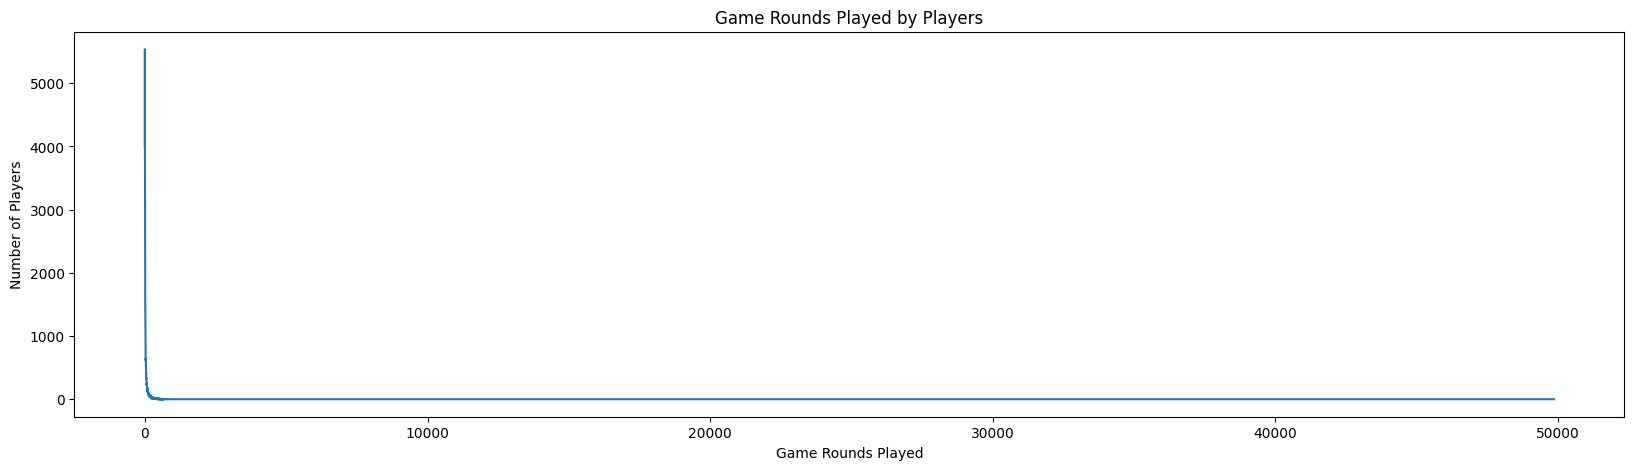

In [14]:
# plot all users for number of rounds played
fig = plt.subplots(figsize = (20, 5))
sns.lineplot(data = roundsPlayed, x = "sum_gamerounds", y = "userid")
plt.title("Game Rounds Played by Players")
plt.xlabel("Game Rounds Played")
plt.ylabel("Number of Players")

Very Right skewed with some outliers compared to other players. With more resources available, we could look into the outlier more to understand the how the user is playing the game. For now, it will be noted as an outlier but since we're focused on player retention, we will keep that data point in the dataset moving forward.

It's still hard to visualize where most of the data lies on the left hand side, so we will condense the data a bit to better see the peak on the left side of the graph and understand what is going on. We'll look at users that played less than 100 rounds and users that played less than 50 rounds.

Text(0, 0.5, 'Number of Players')

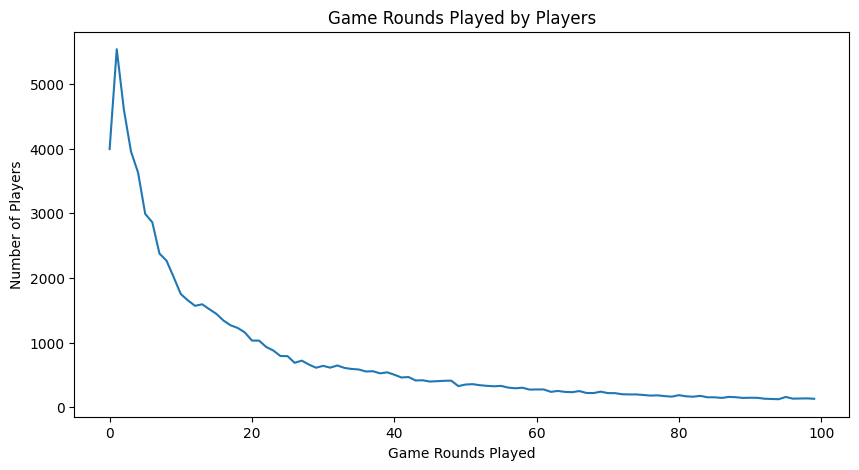

In [15]:
# plot users that played less than 100 rounds
fig = plt.subplots(figsize = (10, 5))
sns.lineplot(data = roundsPlayed.head(100), x = "sum_gamerounds", y = "userid")
plt.title("Game Rounds Played by Players")
plt.xlabel("Game Rounds Played")
plt.ylabel("Number of Players")

Text(0, 0.5, 'Number of Players')

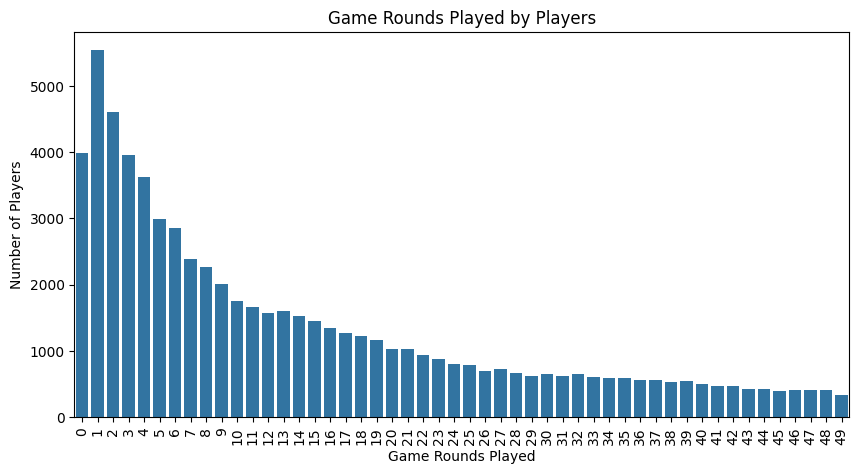

In [16]:
# plot users that played less than 50 rounds
fig = plt.subplots(figsize = (10, 5))
sns.barplot(data = roundsPlayed.head(50), x = "sum_gamerounds", y = "userid")
plt.title("Game Rounds Played by Players")
plt.xlabel("Game Rounds Played")
plt.xticks(rotation = 90)
plt.ylabel("Number of Players")

There is a noticeable decline in users as the number of rounds cleared gets higher, which is understandable. Most users may download a game to try it out and find they don't like it, while some may get hooked!

We can also break this out by the number of users that were retained after 1 and 7 days to see if there is any noticeable difference graphically before doing the A/B Tests.

In [17]:
# count the number of users that cleared a certain number of rounds and whether they were retained after 1 day
gamesPlayed_ret1 = df.groupby(["sum_gamerounds", "retention_1"])["userid"].count().reset_index()
gamesPlayed_ret1

,sum_gamerounds,retention_1,userid
0,0,False,3907
1,0,True,87
2,1,False,5367
3,1,True,171
4,2,False,4332
...,...,...,...
1315,2294,True,1
1316,2438,True,1
1317,2640,True,1
1318,2961,True,1


Text(0, 0.5, 'Number of Players')

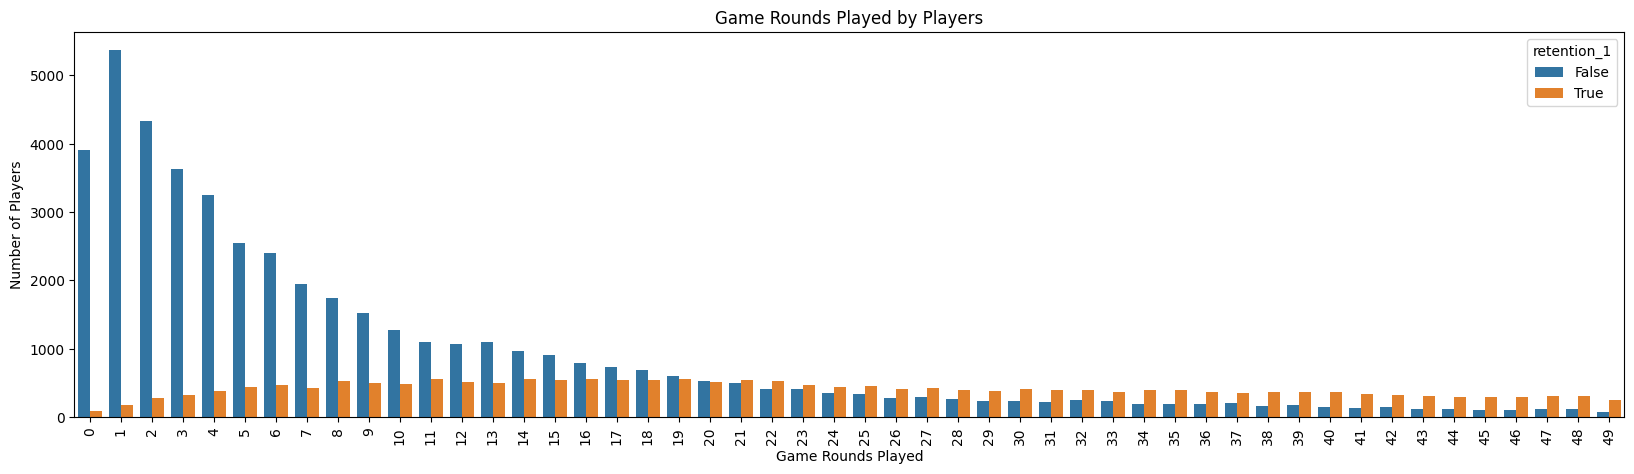

In [18]:
# plot users that played less than 50 rounds grouped by whether they were retained after 1 day
fig = plt.subplots(figsize = (20, 5))
sns.barplot(data = gamesPlayed_ret1.head(100), x = "sum_gamerounds", y = "userid", hue = "retention_1")
plt.title("Game Rounds Played by Players")
plt.xlabel("Game Rounds Played")
plt.xticks(rotation = 90)
plt.ylabel("Number of Players")

As the users clear more levels, they start to be retained more, with some users still quit playing after clearing a number of levels. An interesting observation from the dataset a few cells ago is the user that cleared 49,854 levels wasn't retained after one day. This would be something to investigate further with more data and resources available from the company.

Next we'll see if a similar trend holds for users after 7 days.

In [19]:
# count the number of users that cleared a certain number of rounds and whether they were retained after 7 days
gamesPlayed_ret7 = df.groupby(["sum_gamerounds", "retention_7"])["userid"].count().reset_index()
gamesPlayed_ret7

,sum_gamerounds,retention_7,userid
0,0,False,3965
1,0,True,29
2,1,False,5497
3,1,True,41
4,2,False,4539
...,...,...,...
1378,2294,True,1
1379,2438,True,1
1380,2640,False,1
1381,2961,True,1


Text(0, 0.5, 'Number of Players')

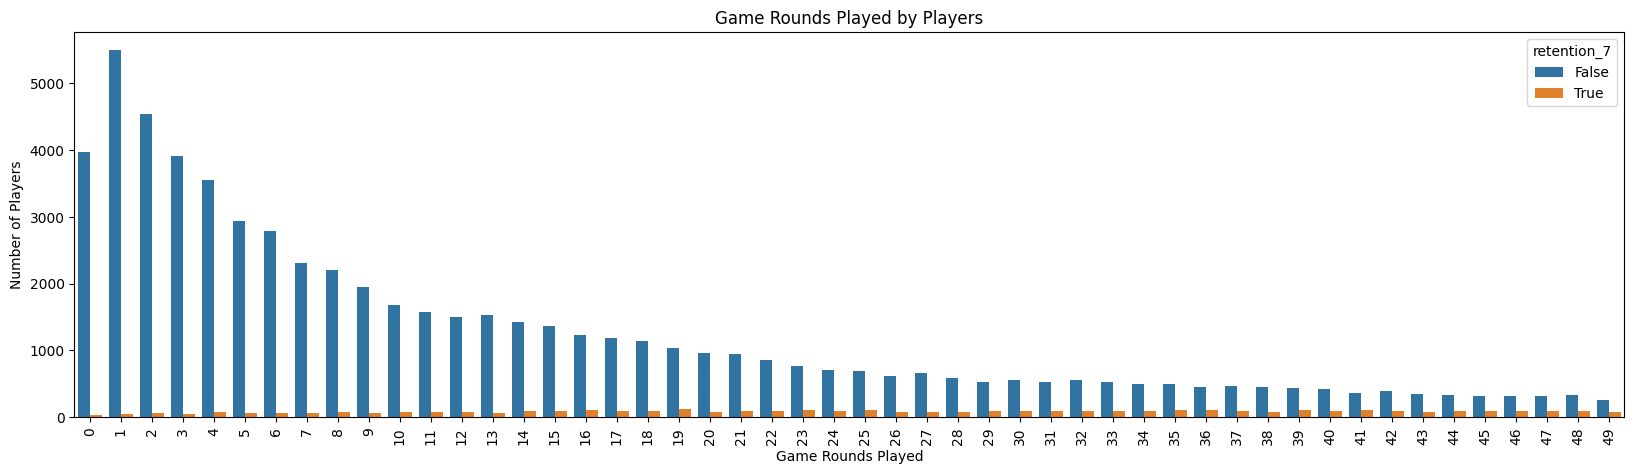

In [20]:
# plot users that played less than 50 rounds grouped by whether they were retained after 1 day
fig = plt.subplots(figsize = (20, 5))
sns.barplot(data = gamesPlayed_ret7.head(100), x = "sum_gamerounds", y = "userid", hue = "retention_7")
plt.title("Game Rounds Played by Players")
plt.xlabel("Game Rounds Played")
plt.xticks(rotation = 90)
plt.ylabel("Number of Players")

## AB Testing

Now that we understand the data a little better, we can move on to testing if there are noticable differences between the two groups.

### 1 Day Retention

We'll start with 1-day retention. We can first look at what the overall 1-day retention was for our data

In [21]:
# the percent of users that played again the day after installing the app and initial playthrogh
df["retention_1"].mean()

0.4452095044850259

In [22]:
# percent of users that played again the day after installing the app and initial playthrough for each version of the gate
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

By observation, there doesn't look to be much of a difference in 1-day retention between the two groups. There is a slight decrease when the gate is moved back to level 40.

#### Bootstrap

This was one test, so we could see different results if we were to run this again. To help with this process, we'll perform a bootstrap to repeatedly re-sample our dataset with replacement and calculate the 1-day retention for the samples. We will resample the data 1000 times. In a production environment we could increase this to something like 10,000 resamples, but we'll keep the calculations simple for this project.

In [23]:
# create an empty list to store the bootstrapped means for each group
boot_1day = []
resamples = 1000

for i in range(resamples):
    group_means = df.sample(frac = 1, replace = True).groupby("version")["retention_1"].mean()

    boot_1day.append(group_means)

# change the list to a dataframe for use
boot_1day = pd.DataFrame(boot_1day)

boot_1day

version,gate_30,gate_40
retention_1,0.446593,0.435671
retention_1,0.446099,0.439704
retention_1,0.445477,0.443361
retention_1,0.449708,0.439104
retention_1,0.451265,0.443769
...,...,...
retention_1,0.439771,0.438333
retention_1,0.451320,0.443643
retention_1,0.446195,0.442467
retention_1,0.448397,0.441982


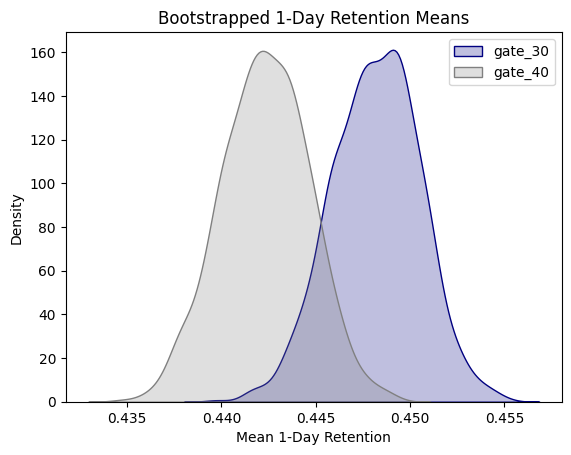

In [24]:
sns.kdeplot(boot_1day["gate_30"], fill = True, color = "navy", label = "gate_30")
sns.kdeplot(boot_1day["gate_40"], fill = True, color = "grey", label = "gate_40")
plt.title("Bootstrapped 1-Day Retention Means")
plt.xlabel("Mean 1-Day Retention")
plt.legend(loc = "upper right")
plt.show()

The bootstrap results shows what the underlying 1-day retention for these two groups could be. We can see that there looks to be some evidence of a difference, but we can examine that difference a bit further.

In [25]:
# calculate the percent difference between our two groups
boot_1day["diff"] = ((boot_1day["gate_30"] - boot_1day["gate_40"])/ boot_1day["gate_40"]) * 100
boot_1day

version,gate_30,gate_40,diff
retention_1,0.446593,0.435671,2.506823
retention_1,0.446099,0.439704,1.454477
retention_1,0.445477,0.443361,0.477303
retention_1,0.449708,0.439104,2.414956
retention_1,0.451265,0.443769,1.689312
...,...,...,...
retention_1,0.439771,0.438333,0.328231
retention_1,0.451320,0.443643,1.730462
retention_1,0.446195,0.442467,0.842564
retention_1,0.448397,0.441982,1.451429


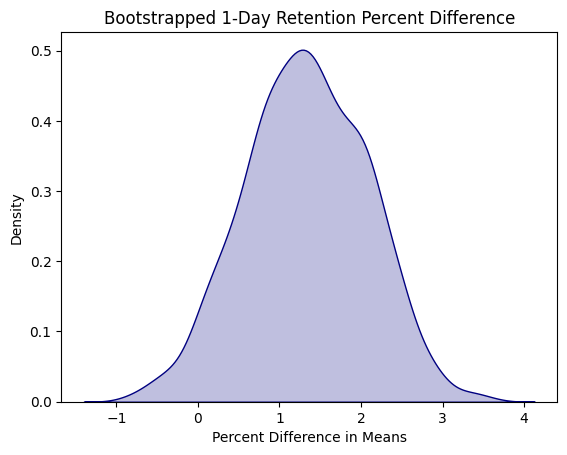

In [26]:
sns.kdeplot(boot_1day["diff"], fill = True, color = "navy")
plt.title("Bootstrapped 1-Day Retention Percent Difference")
plt.xlabel("Percent Difference in Means")
plt.show()

We can see in the above graph that most of the differences fall around 1% - 2%, with most of the distribution being above 0% favoring gate 30. We can calculate the probability that the difference is above 0%.

In [27]:
prob = boot_1day[boot_1day["diff"] > 0].shape[0]/len(boot_1day)

print("Probability of a difference greater than 0 is", "{:.1%}".format(prob))

Probability of a difference greater than 0 is 96.2%


There looks to be a high probability of a difference between the two groups greater than 0%. We can use other techniques to test this difference as well.

#### Chi-Squared Test

In this section we'll use a Chi-Squared Test to compare the two groups. As stated before, we'll use a significance level of 0.05. We'll use the following hypotheses:

$H_0$: The retention rate is the same for both versions of the game vs $H_A$: There is a difference in player retention between the two versions of the game

In [28]:
# show a contingency table for the version and 1 day retention using total number of players
pd.crosstab(index = df["version"], columns = df["retention_1"], margins = True)

retention_1,False,True,All
version,,,
gate_30,24666,20034,44700
gate_40,25370,20119,45489
All,50036,40153,90189


In [29]:
# show a contingency table for the version and 1 day retention using percentages
pd.crosstab(index = df["version"], columns = df["retention_1"], margins = True, normalize = "index") * 100

retention_1,False,True
version,,
gate_30,55.181208,44.818792
gate_40,55.771725,44.228275
All,55.479050,44.520950


The assumptions for a chi-squared test aren't violated, so we can go ahead with our test.

In [30]:
chi_sq_stat_1, p_val_1, dof_1, expect_res_1 =  chi2_contingency(pd.crosstab(index=df["version"], columns=df["retention_1"]))
print('retention_1, chi statistic is', chi_sq_stat_1)
print('retention_1, p-value is', p_val_1)
print('retention_1, degree of freedom is', dof_1)
print('retention_1, expected results is', expect_res_1)

retention_1, chi statistic is 3.1591007878782262
retention_1, p-value is 0.07550476210309086
retention_1, degree of freedom is 1
retention_1, expected results is [[24799.13514952 19900.86485048]
 [25236.86485048 20252.13514952]]


With a p-value of 0.0755, we fail to reject the null hypothesis at the 0.05 significance level. For 1 day of playing, moving the gate from level 30 to level 40 has no statistical impact on player retention. The next thing we can use to examine player retention is a Bayesian Test to see if we get similar results, or if there is more information we can find.

#### Bayesian A/B Testing


In [31]:
# Set up a pymc model and uniform priors for the probabilities of retention for arms A and B
with pm.Model() as day1_model:
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

In [32]:
# Set up pm.Bernoulli distributions to model retentions for arms A and B
with day1_model:
    A = pm.Bernoulli('A', p = A_p, observed = df[df.version == 'gate_30']["retention_1"].values)
    B = pm.Bernoulli('B', p = B_p, observed = df[df.version == 'gate_40']["retention_1"].values)
    AvB = pm.Deterministic('AvB', A_p - B_p)

In [33]:
# Fit the model
with day1_model:
    trace1 = pm.sample(5000)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'A_prob'}>,
       <Axes: title={'center': 'B_prob'}>], dtype=object)

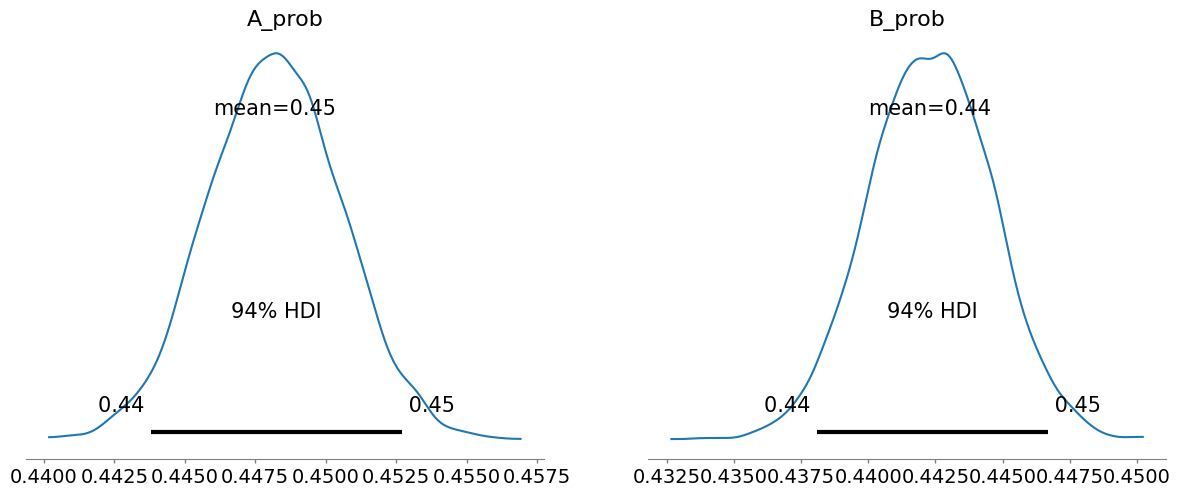

In [34]:
# Plot posterior densities for arms A and B
pm.plot_posterior(trace1["posterior"][["A_prob", "B_prob"]], var_names=['A_prob', 'B_prob'])

In [35]:
def plot_betas(beta_traces, beta_names, colors=['navy','grey']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

<ipython-input-35-a6eb72ccc9b4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
<ipython-input-35-a6eb72ccc9b4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)


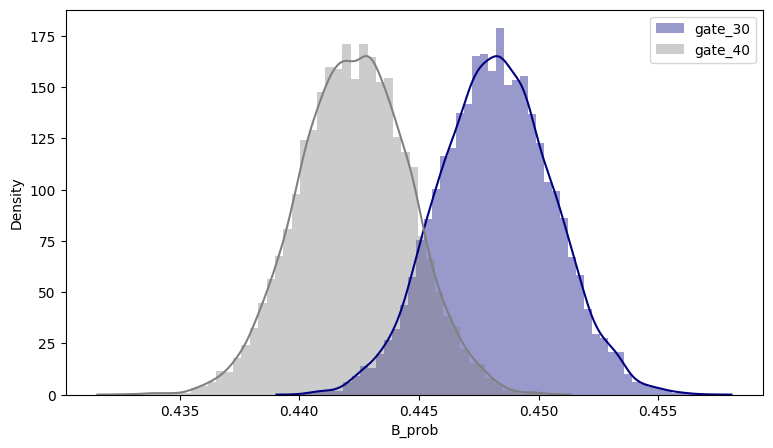

In [36]:
# Plot posterior densities for arms A and B together
plot_betas([trace1["posterior"]['A_prob'],
            trace1["posterior"]['B_prob']],
            ['gate_30','gate_40'])

<Axes: title={'center': 'AvB'}>

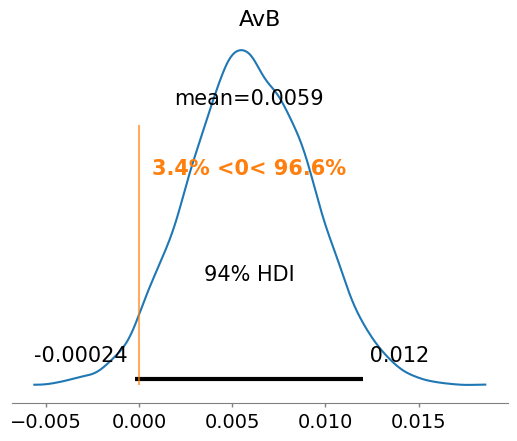

In [37]:
# Plot posterior density for differences with reference line
pm.plot_posterior(trace1["posterior"]["AvB"], var_names='AvB', ref_val=0)

From the Bayesian perspective, the probability that a 1-day retention is greater when the gate is at level 30 is 96.6%.

Next, we will use the same analyses for 7 day retention.

### 7 Day Retention

In [38]:
# the percent of users that played again 7 days after installing the app and initial playthrogh
df["retention_7"].mean()

0.1860648194347426

In [39]:
# percent of users that played again 7 days after installing the app and initial playthrough for each version of the gate
df.groupby("version")["retention_7"].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

#### Bootstrap

In [40]:
# create an empty list to store the bootstrapped means for each group
boot_7days = []
resamples = 1000

for i in range(resamples):
    group_means = df.sample(frac = 1, replace = True).groupby("version")["retention_7"].mean()

    boot_7days.append(group_means)

# change the list to a dataframe for use
boot_7days = pd.DataFrame(boot_7days)

boot_7days

version,gate_30,gate_40
retention_7,0.189336,0.182598
retention_7,0.192149,0.183633
retention_7,0.192732,0.181001
retention_7,0.190440,0.185018
retention_7,0.187304,0.182960
...,...,...
retention_7,0.189879,0.181587
retention_7,0.187462,0.183439
retention_7,0.189369,0.181231
retention_7,0.185708,0.182491


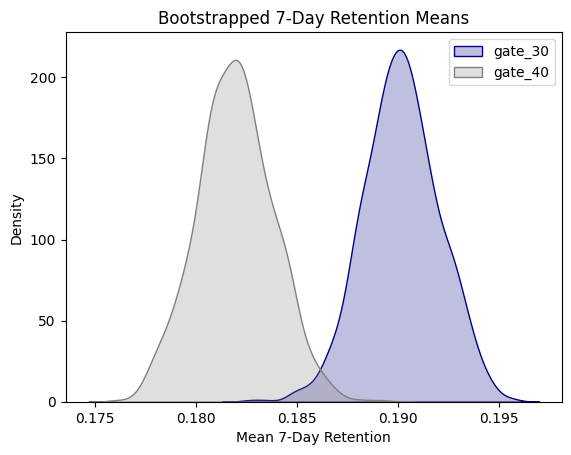

In [41]:
sns.kdeplot(boot_7days["gate_30"], fill = True, color = "navy", label = "gate_30")
sns.kdeplot(boot_7days["gate_40"], fill = True, color = "grey", label = "gate_40")
plt.title("Bootstrapped 7-Day Retention Means")
plt.xlabel("Mean 7-Day Retention")
plt.legend(loc = "upper right")
plt.show()

In [42]:
# calculate the percent difference between our two groups
boot_7days["diff"] = ((boot_7days["gate_30"] - boot_7days["gate_40"])/ boot_7days["gate_40"]) * 100
boot_7days

version,gate_30,gate_40,diff
retention_7,0.189336,0.182598,3.690191
retention_7,0.192149,0.183633,4.637559
retention_7,0.192732,0.181001,6.481159
retention_7,0.190440,0.185018,2.930844
retention_7,0.187304,0.182960,2.374157
...,...,...,...
retention_7,0.189879,0.181587,4.566697
retention_7,0.187462,0.183439,2.193319
retention_7,0.189369,0.181231,4.490447
retention_7,0.185708,0.182491,1.762574


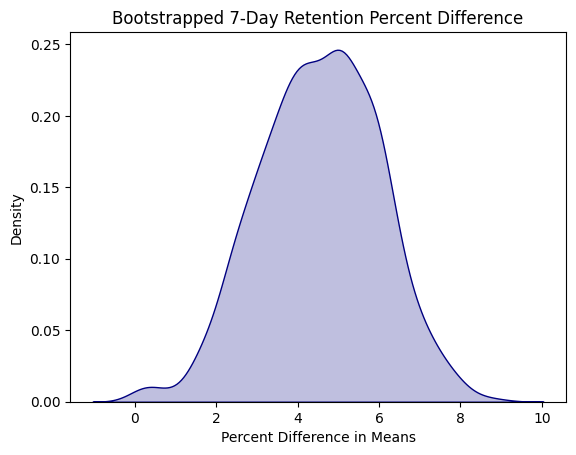

In [43]:
sns.kdeplot(boot_7days["diff"], fill = True, color = "navy")
plt.title("Bootstrapped 7-Day Retention Percent Difference")
plt.xlabel("Percent Difference in Means")
plt.show()

In [44]:
prob = boot_7days[boot_7days["diff"] > 0].shape[0]/len(boot_7days)

print("Probability of a difference greater than 0 is", "{:.1%}".format(prob))

Probability of a difference greater than 0 is 100.0%


There looks to be a high probability of a difference between the two groups greater than 0%. Similar as before, we'll use a Chi-Squared Test to check if there's a statistically significant difference.

#### Chi-Squared Test

As stated before, we'll use a significance level of 0.05. We'll use the same hypotheses:

$H_0$: The retention rate is the same for both versions of the game vs $H_A$: There is a difference in player retention between the two versions of the game

In [45]:
# show a contingency table for the version and 1 day retention using total number of players
pd.crosstab(index = df["version"], columns = df["retention_7"], margins = True)

retention_7,False,True,All
version,,,
gate_30,36198,8502,44700
gate_40,37210,8279,45489
All,73408,16781,90189


In [46]:
# show a contingency table for the version and 1 day retention using percentages
pd.crosstab(index = df["version"], columns = df["retention_7"], margins = True, normalize = "index") * 100

retention_7,False,True
version,,
gate_30,80.979866,19.020134
gate_40,81.799996,18.200004
All,81.393518,18.606482


The assumptions for a chi-squared test aren't violated, so we can go ahead with our test.

In [47]:
chi_sq_stat_7, p_val_7, dof_7, expect_res_7 =  chi2_contingency(pd.crosstab(index=df["version"], columns=df["retention_7"]))
print('retention_7, chi statistic is', chi_sq_stat_7)
print('retention_7, p-value is', p_val_7)
print('retention_7, degree of freedom is', dof_7)
print('retention_7, expected results is', expect_res_7)

retention_7, chi statistic is 9.959086799559167
retention_7, p-value is 0.0016005742679058301
retention_7, degree of freedom is 1
retention_7, expected results is [[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


With a p-value of 0.0016, we reject the null hypothesis at the 0.05 significance level.

#### Bayesian A/B Testing

In [48]:
# Set up a pymc model and uniform priors for the probabilities of retention for arms A and B
with pm.Model() as day7_model:
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)

In [49]:
with day7_model:
    A = pm.Bernoulli('A', p = A_p, observed = df[df.version == 'gate_30']["retention_7"].values)
    B = pm.Bernoulli('B', p = B_p, observed = df[df.version == 'gate_40']["retention_7"].values)
    AvB = pm.Deterministic('AvB', A_p - B_p)

In [50]:
# Fit the model
with day7_model:
    trace7 = pm.sample(5000)

array([<Axes: title={'center': 'A_prob'}>,
       <Axes: title={'center': 'B_prob'}>], dtype=object)

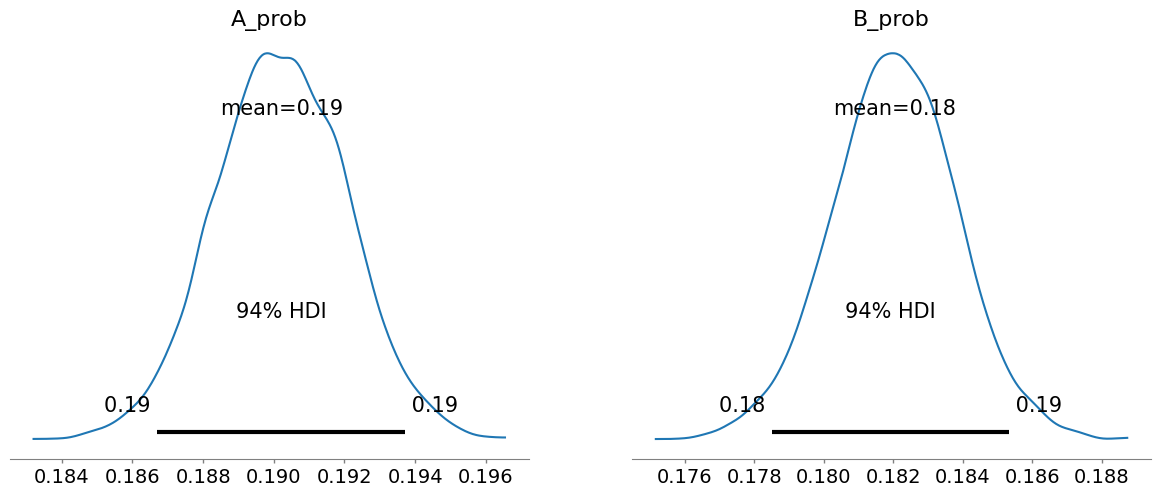

In [51]:
# Plot posterior densities for arms A and B
pm.plot_posterior(trace7["posterior"][["A_prob", "B_prob"]], var_names=['A_prob', 'B_prob'])

<ipython-input-35-a6eb72ccc9b4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
<ipython-input-35-a6eb72ccc9b4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)


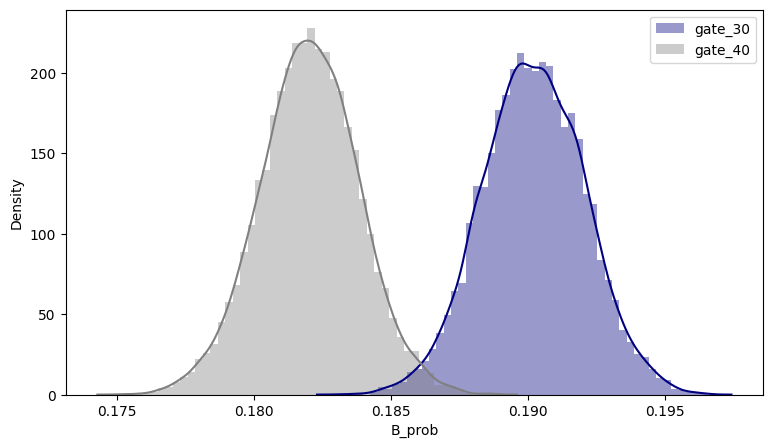

In [52]:
# Plot posterior densities for arms A and B together
plot_betas([trace7["posterior"]['A_prob'],
            trace7["posterior"]['B_prob']],
            ['gate_30','gate_40'])

<Axes: title={'center': 'AvB'}>

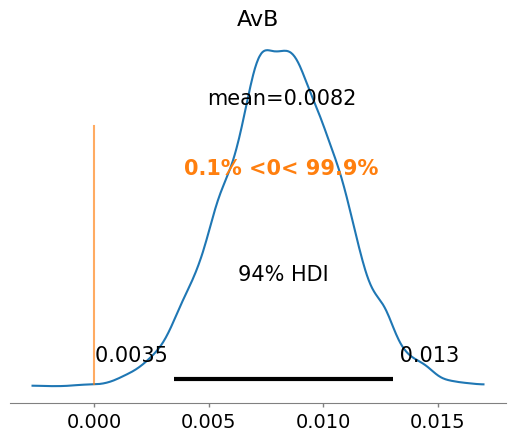

In [53]:
# Plot posterior density for differences with reference line
pm.plot_posterior(trace7["posterior"]["AvB"], var_names='AvB', ref_val=0)

There is a probability of 99.9% that 7-day retention is greater when the gate is at level 30.

## Evalutation and Conclusion

From the bootstrap results, there is evidence that a 7-day retention is higher when the gate is at level 30 and there is some uncertainty in a 1-day retention. The chi-squared test showed similar results, with the 1-day retention failing to reject the null hypothesis and the 7-day retention did reject the null hypothesis. And finally, the Bayesian test had similar findings with the 1-day test had a lower probability of retention at 96.6% with the 7-day retention being at 99.9%.

From all the tests, there is not enough evidence that retention is different after 1 day whether the gate is at level 30 or level 40. Each of the tests also showed there's strong evidence that 7-day retention is different when the gate is at level 30 vs level 40. The Bayesian analysis showed there is a high probability of retaining users when the gate is at level 30 compared to level 40. So we should *not* move the gate from level 30 to level 40 based on the current testing group. This is something that could be reexamined later with more users. 

It was also worth noting that just under 4,000 players didn't play a single level of the game and roughly a quarter of the players playing 5 rounds or less. This could lead into other analyses to try to understand users that have installed the game but barely played it or didn't play it. 